In [1]:
import random
from collections import OrderedDict, defaultdict

import numpy as np
import torch
from matplotlib import pyplot as plt
from torch import nn
from torch.optim import *
from torch.optim.lr_scheduler import *
from torch.utils.data import DataLoader
from torchprofile import profile_macs
from torchvision.datasets import *
from torchvision.transforms import *
from tqdm.auto import tqdm

In [2]:
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed_all(1)


In [3]:
transforms = {
    "train": Compose([
        RandomCrop(32, padding=5),
        RandomHorizontalFlip(),
        ToTensor(),
    ]),
    "test": ToTensor(),
}

dataset= {}
for split in ["train", "test"]:
    dataset[split] = CIFAR10(
        root="./data/cifar10", 
        train=(split=="train"),
        download=True,
        transform=transforms[split]
    )

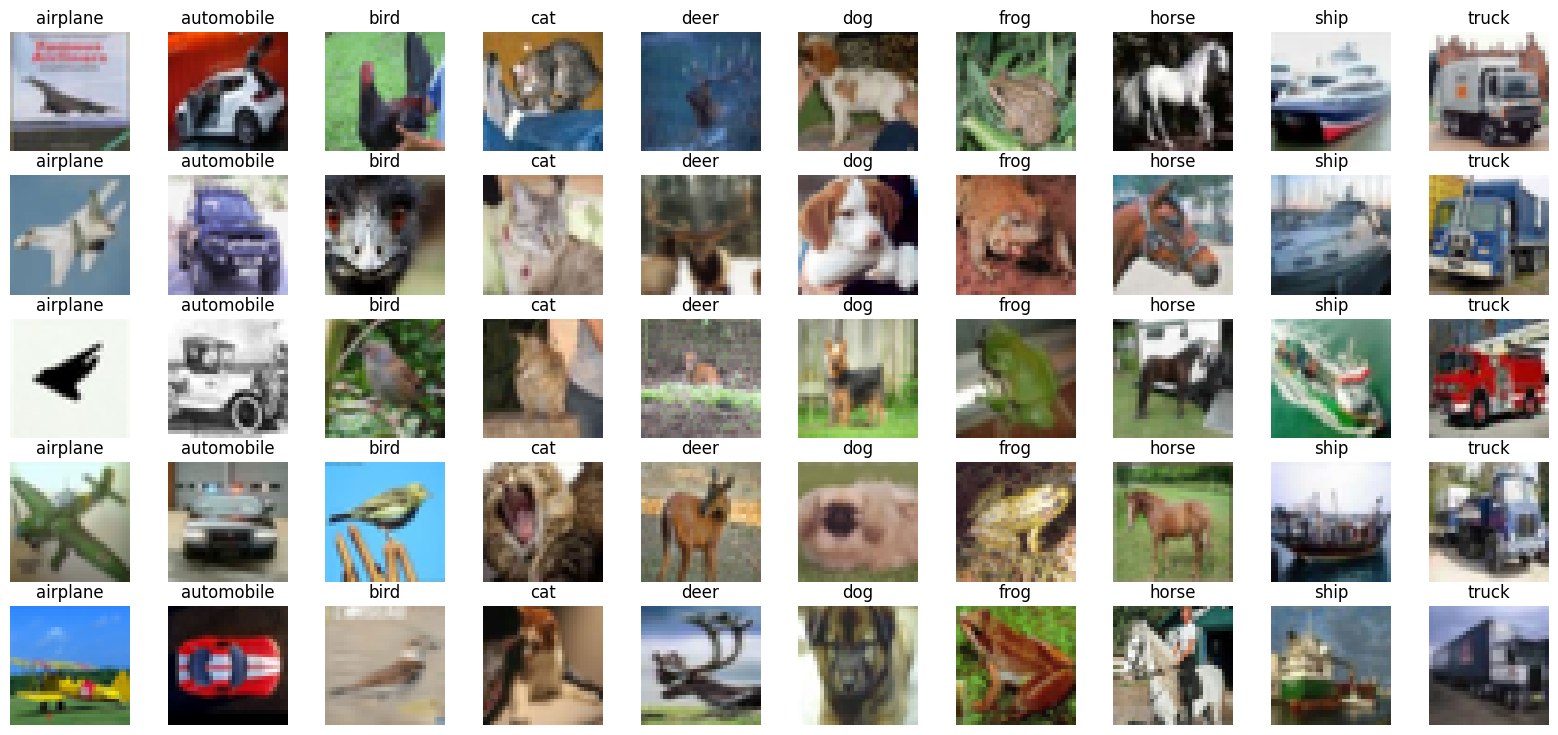

In [4]:
samples = [[] for _ in range(10)]

for image, label in dataset["test"]:
    if len(samples[label]) < 5:
        samples[label].append(image)
plt.figure(figsize=(20,9))

for index in range(50):
    label = index % 10
    #index // 10 
    image = samples[label][index // 10]

    #convert from CHW to HWC for visualization
    image = image.permute(1,2,0)

    #convert from class index to class name
    label = dataset["test"].classes[label]

    plt.subplot(5, 10, index + 1)
    plt.imshow(image)
    plt.title(label)
    plt.axis("off")


In [5]:
dataflow = {}

for split in ["train", "test"]:
    dataflow[split] = DataLoader(
        dataset[split],
        batch_size=256,
        #shuffle=(split=="train"),
        shuffle=True,
        num_workers=0,
        pin_memory=True,
    )

In [6]:
for inputs, targets in dataflow["train"]:
    print(f"inputs dtype: {inputs.dtype}, shape: {inputs.shape}")
    print(f"target dtype: {targets.dtype}, shape: {targets.shape}")
    break

inputs dtype: torch.float32, shape: torch.Size([256, 3, 32, 32])
target dtype: torch.int64, shape: torch.Size([256])


/home/jerry/.local/lib/python3.11/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [7]:
#use VGG-11 
class VGG(nn.Module):
    ARCH = [64, 128, "M", 256, 256, "M", 512, 512, "M", 512, 512, "M"]

    def __init__(self) -> None:
        super().__init__()

        layers = []
        counts = defaultdict(int)
        def add(name:str, layer:nn.Module) -> None:
            layers.append((f"{name}_{counts[name]}", layer))
            counts[name] += 1
        in_channels = 3
        for x in self.ARCH:
            if x != "M":
                # conv-bn-relu
                add("conv", nn.Conv2d(in_channels, x, 3, padding=1, bias=False))
                add("bn", nn.BatchNorm2d(x))
                add("relu", nn.ReLU(inplace=True))
                in_channels = x
            else:
                add("pool", nn.MaxPool2d(2))
        self.backbone = nn.Sequential(OrderedDict(layers))
        self.classifier = nn.Linear(512, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # backbone [batch, 3, 32, 32] -> [batch, 512, 2, 2]
        x = self.backbone(x)

        #avg pool [batch, 512, 2, 2] -> [batch, 512]
        x = x.mean([2, 3])

        # classifier[batch, 512] -> [batch, 10]
        x = self.classifier(x)
        return x
    
model = VGG().cuda()

RuntimeError: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero.

In [ ]:
print(model.backbone)

Sequential(
  (conv_0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn_0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu_0): ReLU(inplace=True)
  (conv_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn_1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu_1): ReLU(inplace=True)
  (pool_0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn_2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu_2): ReLU(inplace=True)
  (conv_3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn_3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu_3): ReLU(inplace=True)
  (pool_1): MaxPool2d(kernel_size=2, stride=2, pad

In [ ]:
print(model.classifier)

Linear(in_features=512, out_features=10, bias=True)


In [ ]:
#calculate the parameters count
num_params = 0
for param in model.parameters():
    if param.requires_grad:
        num_params += param.numel()
print(f"number of trainable parameters: {num_params}")

number of trainable parameters: 9228362


In [ ]:
# The computation cost can be estiamted by the number of MACs (Multiply-Accumulate Operations)
# with TorchProfiler (https://pytorch.org/tutorials/recipes/profiler.html)
num_macs = profile_macs(model, torch.randn(1, 3, 32, 32).cuda())
print(f"number of MACs per forward pass: {num_macs}")

number of MACs per forward pass: 606164480


In [ ]:
#Optimizition
criterion = nn.CrossEntropyLoss()
optimizer = SGD(model.parameters(),
                lr = 0.01,
                momentum=0.9,
                weight_decay=5e-4)

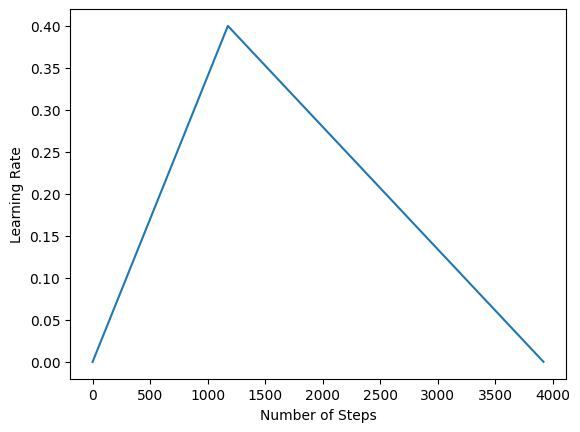

In [ ]:
num_epochs = 20
steps_per_epoch = len(dataflow["train"])

#define the piecewise learning rate scheduler
lr_lambda = lambda step: np.interp(
    [step / steps_per_epoch],
    [0, num_epochs*0.3, num_epochs],
    [0, 1, 0]
)[0]

steps = np.arange(num_epochs*steps_per_epoch)
plt.plot(steps, [lr_lambda(step)*0.4 for step in steps])
plt.xlabel("Number of Steps")
plt.ylabel("Learning Rate")
plt.show()
scheduler = LambdaLR(optimizer, lr_lambda)

In [ ]:
def train(
        model: nn.Module,
        dataflow: DataLoader,
        optimizer: Optimizer,
        criterion: nn.Module,
        scheduler: LambdaLR,
) -> None:
    model.train()

    for inputs, targets in tqdm(dataflow, desc="train", leave=False):
        inputs = inputs.cuda(non_blocking=True)
        targets = targets.cuda(non_blocking=True)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()

        optimizer.step()
        scheduler.step()
        
     

In [ ]:
@torch.inference_mode()
def evaluate( model: nn.Module, dataflow: DataLoader) -> float:
    model.eval()

    num_samples = 0
    num_corrects = 0

    for inputs, targets in tqdm(dataflow, desc="eval", leave=False):
        inputs = inputs.cuda()
        targets = targets.cuda()

        outputs = model(inputs)
        #logits to class indices
        outputs = outputs.argmax(dim=1)

        num_samples += targets.size(0)
        num_corrects += (outputs==targets).sum()

    return (num_corrects / num_samples * 100).item()

In [ ]:
for epoch_num in tqdm(range(1, num_epochs+1)):
    train(model, dataflow["train"], optimizer, criterion, scheduler)
    metric =  evaluate(model, dataflow["test"])
    print(f"epoch {epoch_num}: {metric}")

  0%|          | 0/20 [00:00<?, ?it/s]

train:   0%|          | 0/196 [00:00<?, ?it/s]

eval:   0%|          | 0/40 [00:00<?, ?it/s]

epoch 1: 50.099998474121094


train:   0%|          | 0/196 [00:00<?, ?it/s]

eval:   0%|          | 0/40 [00:00<?, ?it/s]

epoch 2: 56.970001220703125


train:   0%|          | 0/196 [00:00<?, ?it/s]

eval:   0%|          | 0/40 [00:00<?, ?it/s]

epoch 3: 66.37999725341797


train:   0%|          | 0/196 [00:00<?, ?it/s]

eval:   0%|          | 0/40 [00:00<?, ?it/s]

epoch 4: 62.900001525878906


train:   0%|          | 0/196 [00:00<?, ?it/s]

eval:   0%|          | 0/40 [00:00<?, ?it/s]

epoch 5: 67.0199966430664


train:   0%|          | 0/196 [00:00<?, ?it/s]

eval:   0%|          | 0/40 [00:00<?, ?it/s]

epoch 6: 72.94999694824219


train:   0%|          | 0/196 [00:00<?, ?it/s]

eval:   0%|          | 0/40 [00:00<?, ?it/s]

epoch 7: 72.25999450683594


train:   0%|          | 0/196 [00:00<?, ?it/s]

eval:   0%|          | 0/40 [00:00<?, ?it/s]

epoch 8: 81.40999603271484


train:   0%|          | 0/196 [00:00<?, ?it/s]

eval:   0%|          | 0/40 [00:00<?, ?it/s]

epoch 9: 79.78999328613281


train:   0%|          | 0/196 [00:00<?, ?it/s]

eval:   0%|          | 0/40 [00:00<?, ?it/s]

epoch 10: 83.16999816894531


train:   0%|          | 0/196 [00:00<?, ?it/s]

eval:   0%|          | 0/40 [00:00<?, ?it/s]

epoch 11: 81.6500015258789


train:   0%|          | 0/196 [00:00<?, ?it/s]

eval:   0%|          | 0/40 [00:00<?, ?it/s]

epoch 12: 86.93999481201172


train:   0%|          | 0/196 [00:00<?, ?it/s]

eval:   0%|          | 0/40 [00:00<?, ?it/s]

epoch 13: 86.60999298095703


train:   0%|          | 0/196 [00:00<?, ?it/s]

eval:   0%|          | 0/40 [00:00<?, ?it/s]

epoch 14: 87.19999694824219


train:   0%|          | 0/196 [00:00<?, ?it/s]

eval:   0%|          | 0/40 [00:00<?, ?it/s]

epoch 15: 87.73999786376953


train:   0%|          | 0/196 [00:00<?, ?it/s]

eval:   0%|          | 0/40 [00:00<?, ?it/s]

epoch 16: 88.40999603271484


train:   0%|          | 0/196 [00:00<?, ?it/s]

eval:   0%|          | 0/40 [00:00<?, ?it/s]

epoch 17: 88.68000030517578


train:   0%|          | 0/196 [00:00<?, ?it/s]

eval:   0%|          | 0/40 [00:00<?, ?it/s]

epoch 18: 89.62000274658203


train:   0%|          | 0/196 [00:00<?, ?it/s]

eval:   0%|          | 0/40 [00:00<?, ?it/s]

epoch 19: 90.45999908447266


train:   0%|          | 0/196 [00:00<?, ?it/s]

eval:   0%|          | 0/40 [00:00<?, ?it/s]

epoch 20: 90.72999572753906


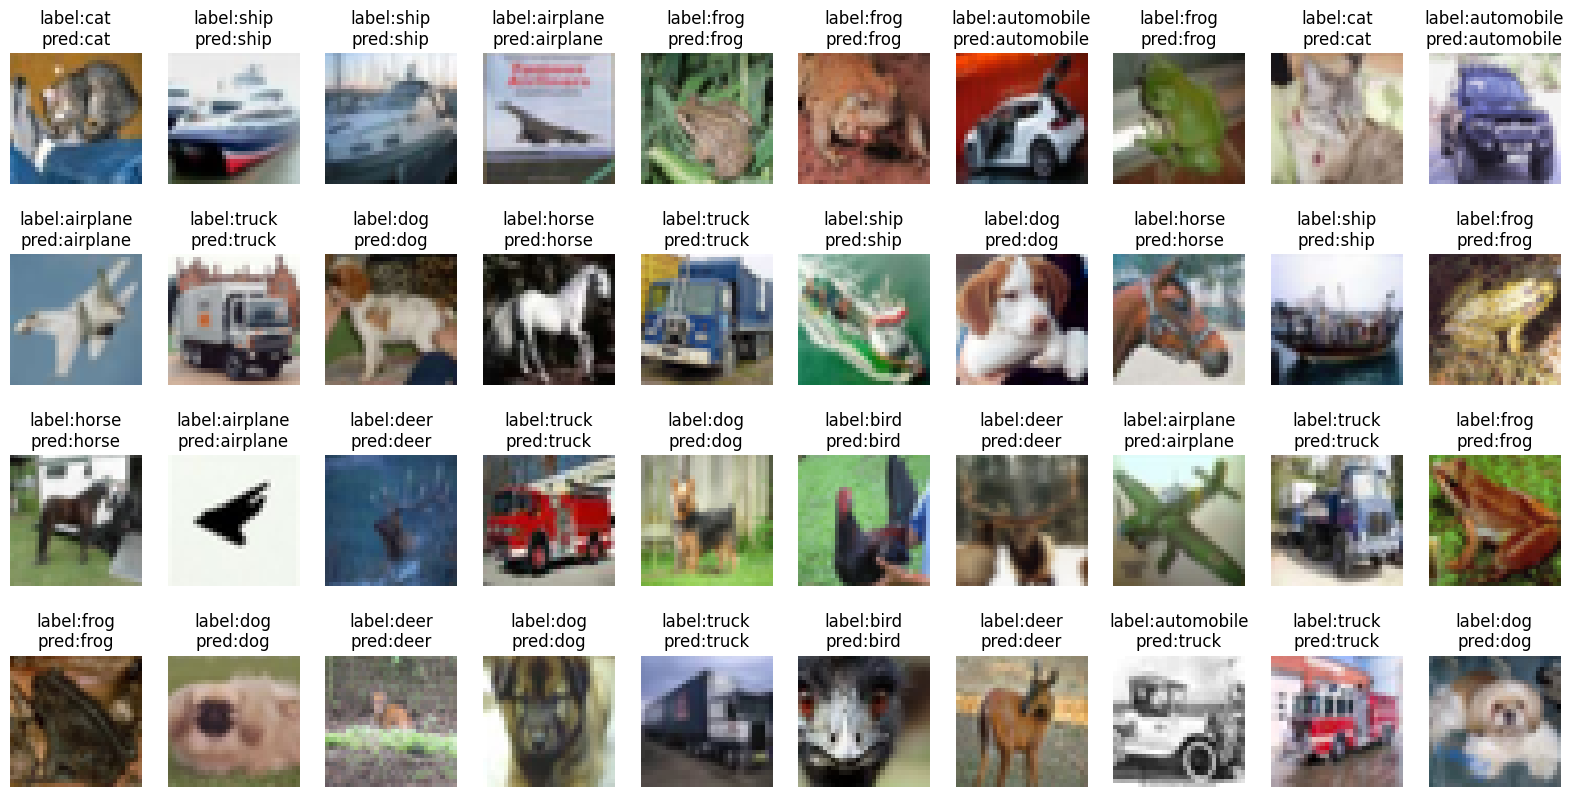

In [ ]:
plt.figure(figsize=(20, 10))
for index in range(40):
    image, label = dataset["test"][index]

    #Model inference
    model.eval()
    with torch.inference_mode():
        pred = model(image.unsqueeze(dim=0).cuda())
        pred = pred.argmax(dim=1)

    image = image.permute(1,2,0)
    label_name = dataset["test"].classes[label]
    pred_name = dataset["test"].classes[pred.item()]

    plt.subplot(4, 10, index + 1)
    plt.imshow(image)
    plt.title(f"label:{label_name}\npred:{pred_name}")
    plt.axis("off")
plt.show()

In [ ]:
from datetime import datetime

def get_time_as_string():
    return datetime.now().strftime('%Y_%m_%d_%H_%M')

# Example usage
current_time = get_time_as_string()
print(f"Current time: {current_time}")
torch.save(model.state_dict(), f"model_{current_time}.pth")

Current time: 2026_01_08_16_51
